# position2vec: профессии в двумерном пространстве

Цель этого блокнота - отобразить множество 149 профессий, которые люди указывают в анкете на кредит (на самом деле, больше, но я провёл предобработку), на двумерную плоскость. 

После этого можно, например, определять сходство любых двух профессий и вообще делать с ними все преобразования, которые возможны в векторном пространстве.

Начнём с импорта библиотек и подключения к местному серверу.

In [1]:
%pylab inline
import pyodbc
import pandas as pd
pd.set_option('display.max_rows', 5000)

from matplotlib import rc
rc('font', **{'family': 'Verdana','weight': 'normal', 'size':8})

import sqlalchemy
import urllib.parse
quoted = urllib.parse.quote_plus('server=olimpus;database=wrk_rsk_anl;driver=sql server;Trusted Connection=yes;')
engine = sqlalchemy.create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted), encoding="cp1251")

Populating the interactive namespace from numpy and matplotlib


Скачаем с сервера:
* обработанное название профессии
* флаги просрочки по кредиту 90+ дней за 12 месяцев с выдачи
* логарифм дохода
* один из уровней образования (от "начального" до "академика")

по 50 тысячам клиентов банка. Мы будем пытаться по профессии предсказать три остальные признака.

In [103]:
data = pd.read_sql('select b.bad_90_12, a.APP_C506, a.app_income_log, a.APP_educ_raw '
                   + ' from Dale_ML16_VARIABLES_app a inner join Dale_ML16_sample0 b '
                  + 'on a.app_id = b.app_id and sample_idx = 1 and rnd < 0.5', engine)
data.shape

(52077, 4)

Сформируем отдельные переменные:
1. position - столбец из n целых чисел - номеров профессий
2. bad_labels - матрица n*2, в первом столбце единички у хороших заёмщиков, во втором - у плохих
3. educations - матрица из семи столбцов с дамми-переменными образования
4. logincome - столбец логарифма дохода

In [104]:
from sklearn.preprocessing import LabelEncoder

position_raw = data[['APP_C506']]
enc = MultiColumnLabelEncoder()
position = pd.DataFrame(enc.fit_transform(position_raw.as_matrix().ravel())
badrate = data[['bad_90_12']]
logincome = data[['app_income_log']]
bad_labels = pd.concat([1-badrate, badrate], axis = 1)
educations = pd.get_dummies(data['APP_educ_raw'])

In [112]:
educations.shape

(52077, 7)

In [109]:
pos_num = len(enc.classes_)

Импортируем из библиотеки Keras (https://keras.io; она у меня стоит поверх TensorFlow) классы для создания модели:
* Input - принимает данные из матрицы
* Embedding - сопоставляет каждому номеру профессии свой вектор
* Dense - обычный полносвязный слой нейросети
* Flatten - слой, превращающий тензоры в двумерные матрицы
* l2 - функция для ридж-регуляризации

In [110]:
from keras.layers import Input, Embedding, Dense, Flatten
from keras.models import Model
from keras.regularizers import l2

Создадим три слоя: для чтения данных (профессий), превращения каждую из input_dim (150) профессий в вектор размерности output_dim (2) с небольшой регуляризацией, и для сплющивания этих векторов в строки.

In [219]:
input_layer = Input(shape = [1], name = 'input')
embed_layer =  Embedding(output_dim=2, input_dim=pos_num+1, input_length=1, W_regularizer = l2(0.0001))(input_layer)
flat_layer = Flatten()(embed_layer)

Над полученными векторами (они соответствуют профессиям) построим простенькую нейронку (5 нейронов скрытого слоя), и три выходных слоя:
* один нейрон с линейной активацией - для дохода
* два нейрона ("хороший" и "плохой"), нормированные к 1 - для кредитного риска
* 7 нейронов, нормированные к 1 - для уровня образования.

In [220]:
dense_layer = Dense(5, activation = 'tanh')(flat_layer)
out1 = Dense(1, activation='linear', name = 'out1')(dense_layer)
out2 = Dense(2, activation='softmax', name = 'out2')(dense_layer)
out3 = Dense(7, activation='softmax', name = 'out3')(dense_layer)

Чтобы понять, какой точности может достичь каждый прогноз, построим и обучим (на 5 итерациях) три отдельные модели:

Модель для дохода:

In [209]:
model1 = Model(input = input_layer, output = out1)
model1.compile(optimizer='adam',loss='mse')
model1.fit(position.as_matrix(), logincome.as_matrix(), nb_epoch=5, batch_size=128)

Epoch 1/5
52077/52077 [==============================] - 2s - loss: 9.3855     
Epoch 2/5
52077/52077 [==============================] - 0s - loss: 0.2245     
Epoch 3/5
52077/52077 [==============================] - 0s - loss: 0.0862     
Epoch 4/5
52077/52077 [==============================] - 0s - loss: 0.0705     
Epoch 5/5
52077/52077 [==============================] - 0s - loss: 0.0659     


Вот такая будет погрешность (в процентах) у модели, определяющей доход. Тринадцать процентов - довольно неплохо!

In [210]:
exp(0.0616*2)-1

0.13111062045087518

Модель для уровня риска:

In [211]:
model2 = Model(input = input_layer, output = out2)
model2.compile(optimizer='adam',loss='categorical_crossentropy')
model2.fit(position.as_matrix(), bad_labels.as_matrix(), nb_epoch=5, batch_size=128)

Epoch 1/5
52077/52077 [==============================] - 2s - loss: 0.5279     
Epoch 2/5
52077/52077 [==============================] - 0s - loss: 0.1821     
Epoch 3/5
52077/52077 [==============================] - 0s - loss: 0.1636     
Epoch 4/5
52077/52077 [==============================] - 0s - loss: 0.1612     
Epoch 5/5
52077/52077 [==============================] - 0s - loss: 0.1602     


Модель для уровня образования:

In [212]:
model3 = Model(input = input_layer, output = out3)
model3.compile(optimizer='adam',loss='categorical_crossentropy')
model3.fit(position.as_matrix(), educations.as_matrix(), nb_epoch=5, batch_size=128)

Epoch 1/5
52077/52077 [==============================] - 2s - loss: 1.2947     
Epoch 2/5
52077/52077 [==============================] - 0s - loss: 1.0353     
Epoch 3/5
52077/52077 [==============================] - 0s - loss: 0.9900     
Epoch 4/5
52077/52077 [==============================] - 0s - loss: 0.9768     
Epoch 5/5
52077/52077 [==============================] - 0s - loss: 0.9706     


Понял, что модели претендуют на потери 0.06, 0.15, 0.95. Что ж, будем взвешивать потери в общей модели так, чтобы все три достигли этого уровня.

Построим общую модель, у которой на выходе все трри переменные, и обучим её на наших данных.

In [221]:
model_common = Model(input = input_layer, output = [out1, out2, out3])

model_common.compile(optimizer='adam',
              loss={'out1': 'mse', 'out2': 'categorical_crossentropy', 'out3': 'categorical_crossentropy'},
              loss_weights={'out1': 1, 'out2': 10, 'out3':0.1})

model_common.fit(position.as_matrix(),{'out1': logincome.as_matrix()
                                       , 'out2': bad_labels.as_matrix()
                                      , 'out3': educations.as_matrix()},nb_epoch=15, batch_size=128)

Epoch 1/15
52077/52077 [==============================] - 2s - loss: 14.4049 - out1_loss: 11.0224 - out2_loss: 0.3232 - out3_loss: 1.4993     
Epoch 2/15
52077/52077 [==============================] - 1s - loss: 2.2075 - out1_loss: 0.4970 - out2_loss: 0.1599 - out3_loss: 1.0935     
Epoch 3/15
52077/52077 [==============================] - 1s - loss: 1.7915 - out1_loss: 0.0929 - out2_loss: 0.1588 - out3_loss: 1.0825     
Epoch 4/15
52077/52077 [==============================] - 1s - loss: 1.7701 - out1_loss: 0.0749 - out2_loss: 0.1584 - out3_loss: 1.0797     
Epoch 5/15
52077/52077 [==============================] - 1s - loss: 1.7623 - out1_loss: 0.0689 - out2_loss: 0.1583 - out3_loss: 1.0783     
Epoch 6/15
52077/52077 [==============================] - 1s - loss: 1.7591 - out1_loss: 0.0667 - out2_loss: 0.1581 - out3_loss: 1.0774     
Epoch 7/15
52077/52077 [==============================] - 1s - loss: 1.7566 - out1_loss: 0.0656 - out2_loss: 0.1580 - out3_loss: 1.0764     
Epoch 8/15


Ура, обучилось! Теперь создадим ещё одну модельку, берущую те самые двумерные векторы профессий

In [222]:
model_embed = Model(input=input_layer, output=flat_layer)
model_embed.compile(optimizer='adam',loss='binary_crossentropy')

Найдём все уникальыне коды профессий и соответстующие им названия

In [223]:
x_plot = position.drop_duplicates().as_matrix()
x_plot_label = position_raw.drop_duplicates().as_matrix().ravel()

Посмотрим, какие числа найдёт модель для 149 профессий:

In [224]:
repres = model_embed.predict(x_plot)
repres.shape

(149, 2)

Без регуляризаторов картинка выглядит кометой: клубок профессий и один хвост. 

С сильной регуляризацией всё сплющивается в одну линию. А вот со слабенькой l2-регуляризацией картинка получается вполне читаемой.

Мы видим довльно интерпретируемую структуру: слева довльно низкоквалифицированыне работники, справа внизу - менеджеры, справа наверху - эксперты. Аналитик (то есть я) находится где-то между разработчиком и доцентом =)

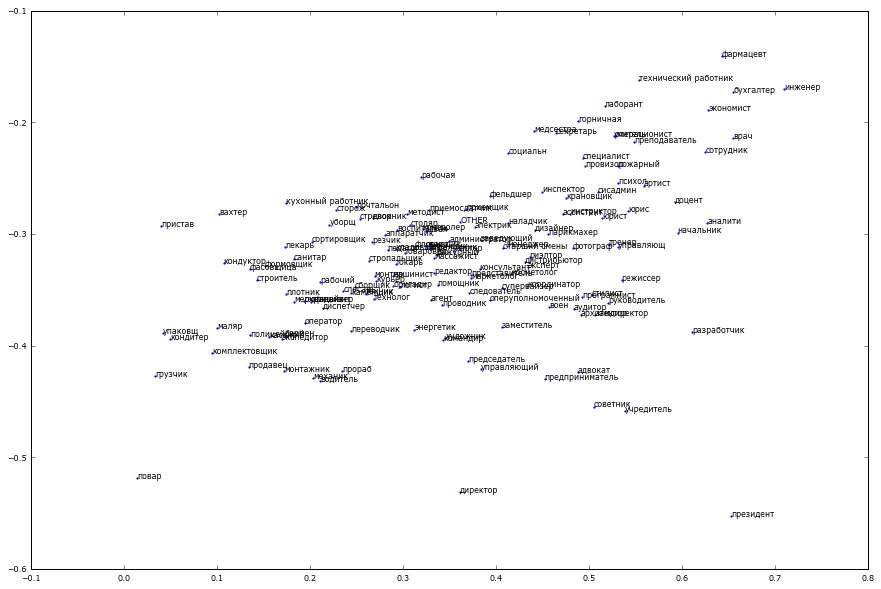

In [225]:
plt.figure(figsize = (15, 10))
plt.scatter(repres[:,0], repres[:,1], s = 5, lw = 0)

for i, txt in enumerate(x_plot_label):
    plt.annotate(txt, (repres[i,0],repres[i,1]))

Конечно, добавив ещё каких-нибудь выходов в модель (например, место работы) мы могли бы ещё улучшить модель, но радость в том, что она даёт интуитивно понятные результаты уже сейчас!

На этом я прощаюсь с вами. В следующий раз будем переводить в линейноые пространства слова (word2vec!).

До встречи!